In [4]:
!pip install -q segmentation-models-pytorch albumentations

import urllib.request, zipfile, os
os.makedirs('data', exist_ok=True)

print("📥 Downloading training dataset (2.6 GB)... this takes 5-10 min")
urllib.request.urlretrieve(
    "https://storage.googleapis.com/duality-public-share/Hackathons/Duality%20Hackathon/Offroad_Segmentation_Training_Dataset.zip",
    "train.zip"
)

print("📥 Downloading test dataset (1.03 GB)... ")
urllib.request.urlretrieve(
    "https://storage.googleapis.com/duality-public-share/Hackathons/Duality%20Hackathon/Offroad_Segmentation_testImages.zip", 
    "test.zip"
)

print("📦 Extracting training data...")
with zipfile.ZipFile("train.zip") as z: 
    z.extractall("data/")

print("📦 Extracting test data...")
with zipfile.ZipFile("test.zip") as z: 
    z.extractall("data/")

print("✅ Done! Checking structure...")

# Show what we got
!ls -R data/ | head -30

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.9 MB/s eta 0:00:0000:01
📥 Downloading training dataset (2.6 GB)... this takes 5-10 min
📥 Downloading test dataset (1.03 GB)... 
📦 Extracting training data...
📦 Extracting test data...
✅ Done! Checking structure...
data/:
Offroad_Segmentation_testImages
Offroad_Segmentation_Training_Dataset

data/Offroad_Segmentation_testImages:
Color_Images
Segmentation

data/Offroad_Segmentation_testImages/Color_Images:
0000060.png
0000061.png
0000062.png
0000063.png
0000064.png
0000065.png
0000066.png
0000067.png
0000068.png
0000069.png
0000070.png
0000071.png
0000072.png
0000073.png
0000074.png
0000075.png
0000076.png
0000077.png
0000078.png
0000079.png
0000080.png
ls: write error: Broken pipe


In [5]:
from pathlib import Path

# Check training data structure
print("📂 Training Dataset Structure:")
train_base = Path("data/Offroad_Segmentation_Training_Dataset")

if (train_base / "train").exists():
    print(f"\n✅ Found train folder")
    train_colored = list((train_base / "train").rglob("*.png"))
    print(f"   📸 Images in train: {len(train_colored)}")
    
if (train_base / "val").exists():
    print(f"\n✅ Found val folder")
    val_colored = list((train_base / "val").rglob("*.png"))
    print(f"   📸 Images in val: {len(val_colored)}")

# Check test data
print("\n📂 Test Dataset Structure:")
test_base = Path("data/Offroad_Segmentation_testImages/Color_Images")
test_images = list(test_base.glob("*.png"))
print(f"✅ Test images: {len(test_images)}")

# Show sample paths
print("\n📁 Sample paths:")
if train_colored:
    print(f"Train image: {train_colored[0]}")
if val_colored:
    print(f"Val image: {val_colored[0]}")
if test_images:
    print(f"Test image: {test_images[0]}")

📂 Training Dataset Structure:

✅ Found train folder
   📸 Images in train: 5714

✅ Found val folder
   📸 Images in val: 634

📂 Test Dataset Structure:
✅ Test images: 1002

📁 Sample paths:
Train image: data/Offroad_Segmentation_Training_Dataset/train/Segmentation/mt0000115.png
Val image: data/Offroad_Segmentation_Training_Dataset/val/Segmentation/cc0000431.png
Test image: data/Offroad_Segmentation_testImages/Color_Images/0000964.png


In [6]:
from pathlib import Path

# Define base paths
TRAIN_DIR = Path("data/Offroad_Segmentation_Training_Dataset/train")
VAL_DIR = Path("data/Offroad_Segmentation_Training_Dataset/val")
TEST_DIR = Path("data/Offroad_Segmentation_testImages/Color_Images")

print("✅ Paths configured:")
print(f"   TRAIN_DIR: {TRAIN_DIR}")
print(f"   VAL_DIR: {VAL_DIR}")
print(f"   TEST_DIR: {TEST_DIR}")

# Verify they exist
assert TRAIN_DIR.exists(), f"Training dir not found: {TRAIN_DIR}"
assert VAL_DIR.exists(), f"Validation dir not found: {VAL_DIR}"
assert TEST_DIR.exists(), f"Test dir not found: {TEST_DIR}"

print("\n✅ All paths verified!")

✅ Paths configured:
   TRAIN_DIR: data/Offroad_Segmentation_Training_Dataset/train
   VAL_DIR: data/Offroad_Segmentation_Training_Dataset/val
   TEST_DIR: data/Offroad_Segmentation_testImages/Color_Images

✅ All paths verified!


In [8]:
from pathlib import Path

train_path = Path("data/Offroad_Segmentation_Training_Dataset/train")
val_path = Path("data/Offroad_Segmentation_Training_Dataset/val")

print("📂 Train folder contents:")
for item in sorted(train_path.iterdir()):
    if item.is_dir():
        files = list(item.glob("*"))[:3]
        print(f"  📁 {item.name}/ ({len(list(item.parent.glob(item.name + '/*')))} files)")
        if files:
            print(f"     Sample: {files[0].name}")

print("\n📂 Val folder contents:")  
for item in sorted(val_path.iterdir()):
    if item.is_dir():
        files = list(item.glob("*"))[:3]
        print(f"  📁 {item.name}/ ({len(list(item.parent.glob(item.name + '/*')))} files)")
        if files:
            print(f"     Sample: {files[0].name}")

📂 Train folder contents:
  📁 Color_Images/ (2857 files)
     Sample: mt0000115.png
  📁 Segmentation/ (2857 files)
     Sample: mt0000115.png

📂 Val folder contents:
  📁 Color_Images/ (317 files)
     Sample: cc0000431.png
  📁 Segmentation/ (317 files)
     Sample: cc0000431.png


In [10]:
# Modified train.py for Kaggle environment

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import cv2
import os
from tqdm.auto import tqdm

# ============================================================================
# Configuration for Kaggle
# ============================================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")

# Paths (adjusted for Kaggle)
TRAIN_DIR = 'data/Offroad_Segmentation_Training_Dataset/train'
VAL_DIR = 'data/Offroad_Segmentation_Training_Dataset/val'
OUTPUT_DIR = 'results'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Hyperparameters
BATCH_SIZE = 2  # Increased from 2 (Kaggle has more memory)
IMG_WIDTH = int(((960 / 2) // 14) * 14)
IMG_HEIGHT = int(((540 / 2) // 14) * 14)
LEARNING_RATE = 1e-4
NUM_EPOCHS = 10  # Increased from 10

print(f"📊 Configuration:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Image size: {IMG_HEIGHT}x{IMG_WIDTH}")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Epochs: {NUM_EPOCHS}")

# ============================================================================
# Class Mapping
# ============================================================================
value_map = {
    0: 0,        # background
    100: 1,      # Trees
    200: 2,      # Lush Bushes
    300: 3,      # Dry Grass
    500: 4,      # Dry Bushes
    550: 5,      # Ground Clutter
    700: 6,      # Logs
    800: 7,      # Rocks
    7100: 8,     # Landscape
    10000: 9     # Sky
}
NUM_CLASSES = len(value_map)

def convert_mask(mask):
    """Convert raw mask values to class IDs."""
    arr = np.array(mask)
    new_arr = np.zeros_like(arr, dtype=np.uint8)
    for raw_value, new_value in value_map.items():
        new_arr[arr == raw_value] = new_value
    return Image.fromarray(new_arr)

# ============================================================================
# Dataset
# ============================================================================
class MaskDataset(Dataset):
    def __init__(self, data_dir, transform=None, mask_transform=None):
        self.image_dir = os.path.join(data_dir, 'Color_Images')
        self.masks_dir = os.path.join(data_dir, 'Segmentation')
        self.transform = transform
        self.mask_transform = mask_transform
        
        # Get list of image files
        if os.path.exists(self.image_dir):
            self.data_ids = [f for f in os.listdir(self.image_dir) if f.endswith('.png')]
        else:
            raise FileNotFoundError(f"Image directory not found: {self.image_dir}")
        
        print(f"   Found {len(self.data_ids)} images in {data_dir}")

    def __len__(self):
        return len(self.data_ids)

    def __getitem__(self, idx):
        data_id = self.data_ids[idx]
        img_path = os.path.join(self.image_dir, data_id)
        mask_path = os.path.join(self.masks_dir, data_id)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = convert_mask(mask)

        if self.transform:
            image = self.transform(image)
            mask = self.mask_transform(mask) * 255

        return image, mask

# ============================================================================
# Model
# ============================================================================
class SegmentationHeadConvNeXt(nn.Module):
    def __init__(self, in_channels, out_channels, tokenW, tokenH):
        super().__init__()
        self.H, self.W = tokenH, tokenW

        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, 128, kernel_size=7, padding=3),
            nn.GELU()
        )

        self.block = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=7, padding=3, groups=128),
            nn.GELU(),
            nn.Conv2d(128, 128, kernel_size=1),
            nn.GELU(),
        )

        self.classifier = nn.Conv2d(128, out_channels, 1)

    def forward(self, x):
        B, N, C = x.shape
        x = x.reshape(B, self.H, self.W, C).permute(0, 3, 1, 2)
        x = self.stem(x)
        x = self.block(x)
        return self.classifier(x)

# ============================================================================
# Metrics
# ============================================================================
def compute_iou(pred, target, num_classes=10):
    """Compute IoU for each class and return mean IoU."""
    pred = torch.argmax(pred, dim=1)
    pred, target = pred.view(-1), target.view(-1)

    iou_per_class = []
    for class_id in range(num_classes):
        pred_inds = pred == class_id
        target_inds = target == class_id

        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()

        if union == 0:
            iou_per_class.append(float('nan'))
        else:
            iou_per_class.append((intersection / union).cpu().item())

    return np.nanmean(iou_per_class), iou_per_class

print("✅ All functions defined!")

✅ Using device: cuda
📊 Configuration:
   Batch size: 2
   Image size: 266x476
   Learning rate: 0.0001
   Epochs: 10
✅ All functions defined!


In [3]:
import torchvision.transforms as transforms

In [11]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
])

# Create datasets
print("📦 Loading datasets...")
trainset = MaskDataset(data_dir=TRAIN_DIR, transform=transform, mask_transform=mask_transform)
valset = MaskDataset(data_dir=VAL_DIR, transform=transform, mask_transform=mask_transform)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✅ Training samples: {len(trainset)}")
print(f"✅ Validation samples: {len(valset)}")

# Load DINOv2 backbone
print("\n🔄 Loading DINOv2 backbone (this takes 2-3 min)...")
BACKBONE_SIZE = "small"  # Options: small, base, large, giant
backbone_archs = {
    "small": "vits14",
    "base": "vitb14",
    "large": "vitl14",
    "giant": "vitg14",
}
backbone_arch = backbone_archs[BACKBONE_SIZE]
backbone_name = f"dinov2_{backbone_arch}"

backbone = torch.hub.load(repo_or_dir="facebookresearch/dinov2", model=backbone_name)
backbone.eval()
backbone.to(device)
print("✅ Backbone loaded!")

# Get embedding dimension
imgs, _ = next(iter(train_loader))
imgs = imgs.to(device)
with torch.no_grad():
    output = backbone.forward_features(imgs)["x_norm_patchtokens"]
n_embedding = output.shape[2]
print(f"✅ Embedding dimension: {n_embedding}")

# Create segmentation head
model = SegmentationHeadConvNeXt(
    in_channels=n_embedding,
    out_channels=NUM_CLASSES,
    tokenW=IMG_WIDTH // 14,
    tokenH=IMG_HEIGHT // 14
)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

print("✅ Model ready to train!")

📦 Loading datasets...
   Found 2857 images in data/Offroad_Segmentation_Training_Dataset/train
   Found 317 images in data/Offroad_Segmentation_Training_Dataset/val
✅ Training samples: 2857
✅ Validation samples: 317

🔄 Loading DINOv2 backbone (this takes 2-3 min)...
Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth


100%|██████████| 84.2M/84.2M [00:00<00:00, 259MB/s]


✅ Backbone loaded!
✅ Embedding dimension: 384
✅ Model ready to train!


In [12]:
# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'train_iou': [],
    'val_iou': []
}

best_val_iou = 0.0

print(f"\n🚀 Starting training for {NUM_EPOCHS} epochs...")
print("=" * 80)

for epoch in range(NUM_EPOCHS):
    # TRAINING
    model.train()
    train_losses = []
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device), labels.to(device)

        # Get features from backbone (frozen)
        with torch.no_grad():
            features = backbone.forward_features(imgs)["x_norm_patchtokens"]

        # Forward pass through segmentation head
        logits = model(features)
        outputs = F.interpolate(logits, size=imgs.shape[2:], mode="bilinear", align_corners=False)

        labels = labels.squeeze(dim=1).long()
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})

    # VALIDATION
    model.eval()
    val_losses = []
    all_val_ious = []
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]")
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)

            features = backbone.forward_features(imgs)["x_norm_patchtokens"]
            logits = model(features)
            outputs = F.interpolate(logits, size=imgs.shape[2:], mode="bilinear", align_corners=False)

            labels = labels.squeeze(dim=1).long()
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())

            # Calculate IoU
            iou, _ = compute_iou(outputs, labels, NUM_CLASSES)
            all_val_ious.append(iou)
            
            pbar.set_postfix({'loss': f"{loss.item():.4f}", 'iou': f"{iou:.4f}"})

    # Record metrics
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_val_iou = np.nanmean(all_val_ious)

    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    history['val_iou'].append(epoch_val_iou)

    print(f"\n📊 Epoch {epoch+1}/{NUM_EPOCHS}:")
    print(f"   Train Loss: {epoch_train_loss:.4f}")
    print(f"   Val Loss:   {epoch_val_loss:.4f}")
    print(f"   Val IoU:    {epoch_val_iou:.4f}")

    # Save best model
    if epoch_val_iou > best_val_iou:
        best_val_iou = epoch_val_iou
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_iou': epoch_val_iou,
        }, os.path.join(OUTPUT_DIR, 'best_model.pth'))
        print(f"   💾 Saved best model (IoU: {epoch_val_iou:.4f})")

    print("=" * 80)

print(f"\n✅ Training complete!")
print(f"🏆 Best validation IoU: {best_val_iou:.4f}")


🚀 Starting training for 10 epochs...


Epoch 1/10 [Train]:   0%|          | 0/1429 [00:00<?, ?it/s]

Epoch 1/10 [Val]:   0%|          | 0/159 [00:00<?, ?it/s]


📊 Epoch 1/10:
   Train Loss: 1.1796
   Val Loss:   0.9950
   Val IoU:    0.2377
   💾 Saved best model (IoU: 0.2377)


Epoch 2/10 [Train]:   0%|          | 0/1429 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ad73d368900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ad73d368900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 2/10 [Val]:   0%|          | 0/159 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ad73d368900>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ad73d368900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
        self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():    
if w.is_alive():  
          ^ ^ ^^^^Exception ignored in: ^^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7ad73d368900>Exception ignored in: ^
^Traceback (most recent call last):
^<function _MultiProcessingDataLoaderIter.__de


📊 Epoch 2/10:
   Train Loss: 0.9495
   Val Loss:   0.9140
   Val IoU:    0.2626
   💾 Saved best model (IoU: 0.2626)


Epoch 3/10 [Train]:   0%|          | 0/1429 [00:00<?, ?it/s]

Epoch 3/10 [Val]:   0%|          | 0/159 [00:00<?, ?it/s]


📊 Epoch 3/10:
   Train Loss: 0.8975
   Val Loss:   0.8790
   Val IoU:    0.2798
   💾 Saved best model (IoU: 0.2798)


Epoch 4/10 [Train]:   0%|          | 0/1429 [00:00<?, ?it/s]

Epoch 4/10 [Val]:   0%|          | 0/159 [00:00<?, ?it/s]


📊 Epoch 4/10:
   Train Loss: 0.8714
   Val Loss:   0.8582
   Val IoU:    0.2947
   💾 Saved best model (IoU: 0.2947)


Epoch 5/10 [Train]:   0%|          | 0/1429 [00:00<?, ?it/s]

Epoch 5/10 [Val]:   0%|          | 0/159 [00:00<?, ?it/s]


📊 Epoch 5/10:
   Train Loss: 0.8551
   Val Loss:   0.8449
   Val IoU:    0.3025
   💾 Saved best model (IoU: 0.3025)


Epoch 6/10 [Train]:   0%|          | 0/1429 [00:00<?, ?it/s]

Epoch 6/10 [Val]:   0%|          | 0/159 [00:00<?, ?it/s]


📊 Epoch 6/10:
   Train Loss: 0.8436
   Val Loss:   0.8358
   Val IoU:    0.3044
   💾 Saved best model (IoU: 0.3044)


Epoch 7/10 [Train]:   0%|          | 0/1429 [00:00<?, ?it/s]

Epoch 7/10 [Val]:   0%|          | 0/159 [00:00<?, ?it/s]


📊 Epoch 7/10:
   Train Loss: 0.8351
   Val Loss:   0.8279
   Val IoU:    0.3087
   💾 Saved best model (IoU: 0.3087)


Epoch 8/10 [Train]:   0%|          | 0/1429 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ad73d368900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ad73d368900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 8/10 [Val]:   0%|          | 0/159 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ad73d368900>    <function _MultiProcessingDataLoaderIter.__del__ at 0x7ad73d368900>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()Exception ignored in: 
self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7ad73d368900>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    
    Traceback (most recent call last):
if w.is_alive():if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in 


📊 Epoch 8/10:
   Train Loss: 0.8285
   Val Loss:   0.8223
   Val IoU:    0.3088
   💾 Saved best model (IoU: 0.3088)


Epoch 9/10 [Train]:   0%|          | 0/1429 [00:00<?, ?it/s]

Epoch 9/10 [Val]:   0%|          | 0/159 [00:00<?, ?it/s]


📊 Epoch 9/10:
   Train Loss: 0.8231
   Val Loss:   0.8178
   Val IoU:    0.3122
   💾 Saved best model (IoU: 0.3122)


Epoch 10/10 [Train]:   0%|          | 0/1429 [00:00<?, ?it/s]

Epoch 10/10 [Val]:   0%|          | 0/159 [00:00<?, ?it/s]


📊 Epoch 10/10:
   Train Loss: 0.8187
   Val Loss:   0.8132
   Val IoU:    0.3169
   💾 Saved best model (IoU: 0.3169)

✅ Training complete!
🏆 Best validation IoU: 0.3169


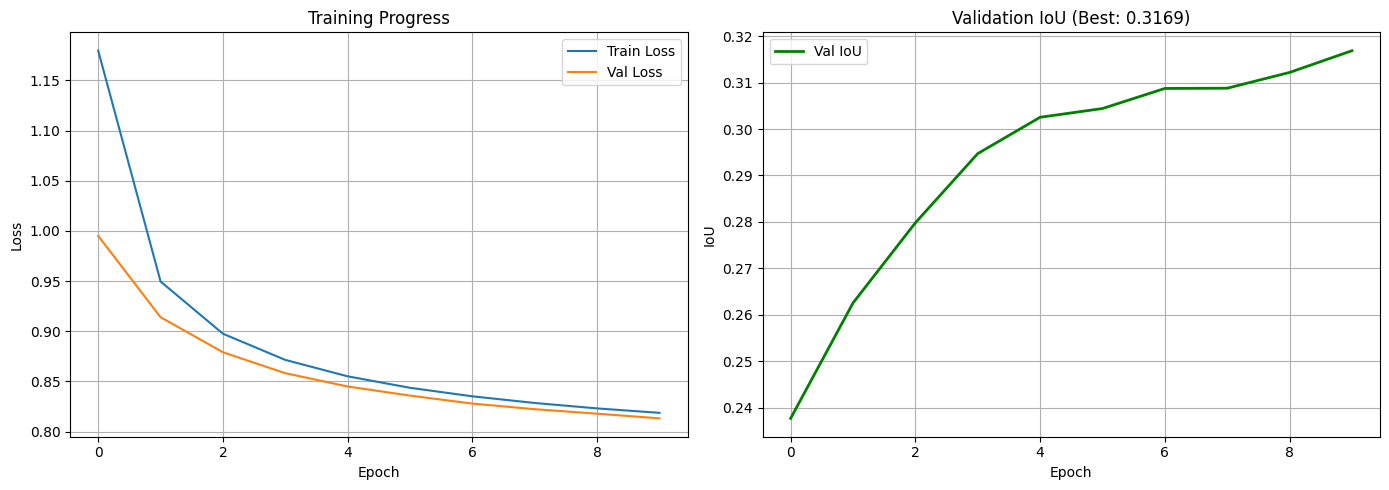

✅ Saved plots to results/training_curves.png

🎯 BASELINE IoU SCORE: 0.3169


In [13]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss')
axes[0].plot(history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Progress')
axes[0].legend()
axes[0].grid(True)

# IoU
axes[1].plot(history['val_iou'], label='Val IoU', color='green', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU')
axes[1].set_title(f'Validation IoU (Best: {best_val_iou:.4f})')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_curves.png'), dpi=150)
plt.show()

print(f"✅ Saved plots to {OUTPUT_DIR}/training_curves.png")
print(f"\n🎯 BASELINE IoU SCORE: {best_val_iou:.4f}")

In [14]:
import pandas as pd
from IPython.display import display, HTML

# Create performance summary
summary_data = {
    'Metric': [
        'Best Validation IoU',
        'Final Training Loss',
        'Final Validation Loss',
        'Total Epochs',
        'Batch Size',
        'Learning Rate',
        'Backbone',
        'Image Size',
        'Number of Classes'
    ],
    'Value': [
        f'{best_val_iou:.4f}',
        f'{history["train_loss"][-1]:.4f}',
        f'{history["val_loss"][-1]:.4f}',
        NUM_EPOCHS,
        BATCH_SIZE,
        LEARNING_RATE,
        BACKBONE_SIZE,
        f'{IMG_HEIGHT}x{IMG_WIDTH}',
        NUM_CLASSES
    ]
}

df_summary = pd.DataFrame(summary_data)

print("=" * 60)
print("📊 BASELINE MODEL PERFORMANCE SUMMARY")
print("=" * 60)
display(df_summary)

# Save to CSV
df_summary.to_csv(os.path.join(OUTPUT_DIR, 'baseline_summary.csv'), index=False)
print(f"\n✅ Saved summary to {OUTPUT_DIR}/baseline_summary.csv")

📊 BASELINE MODEL PERFORMANCE SUMMARY


,Metric,Value
0,Best Validation IoU,0.3169
1,Final Training Loss,0.8187
2,Final Validation Loss,0.8132
3,Total Epochs,10
4,Batch Size,2
5,Learning Rate,0.0001
6,Backbone,small
7,Image Size,266x476
8,Number of Classes,10



✅ Saved summary to results/baseline_summary.csv


In [15]:
# Create epoch-by-epoch history table
history_data = {
    'Epoch': list(range(1, len(history['train_loss']) + 1)),
    'Train Loss': [f'{loss:.4f}' for loss in history['train_loss']],
    'Val Loss': [f'{loss:.4f}' for loss in history['val_loss']],
    'Val IoU': [f'{iou:.4f}' for iou in history['val_iou']]
}

df_history = pd.DataFrame(history_data)

print("\n📈 EPOCH-BY-EPOCH TRAINING HISTORY")
print("=" * 60)
display(df_history)

# Save to CSV
df_history.to_csv(os.path.join(OUTPUT_DIR, 'training_history.csv'), index=False)
print(f"\n✅ Saved history to {OUTPUT_DIR}/training_history.csv")


📈 EPOCH-BY-EPOCH TRAINING HISTORY


,Epoch,Train Loss,Val Loss,Val IoU
0,1,1.1796,0.9950,0.2377
1,2,0.9495,0.9140,0.2626
2,3,0.8975,0.8790,0.2798
3,4,0.8714,0.8582,0.2947
4,5,0.8551,0.8449,0.3025
5,6,0.8436,0.8358,0.3044
6,7,0.8351,0.8279,0.3087
7,8,0.8285,0.8223,0.3088
8,9,0.8231,0.8178,0.3122
9,10,0.8187,0.8132,0.3169



✅ Saved history to results/training_history.csv


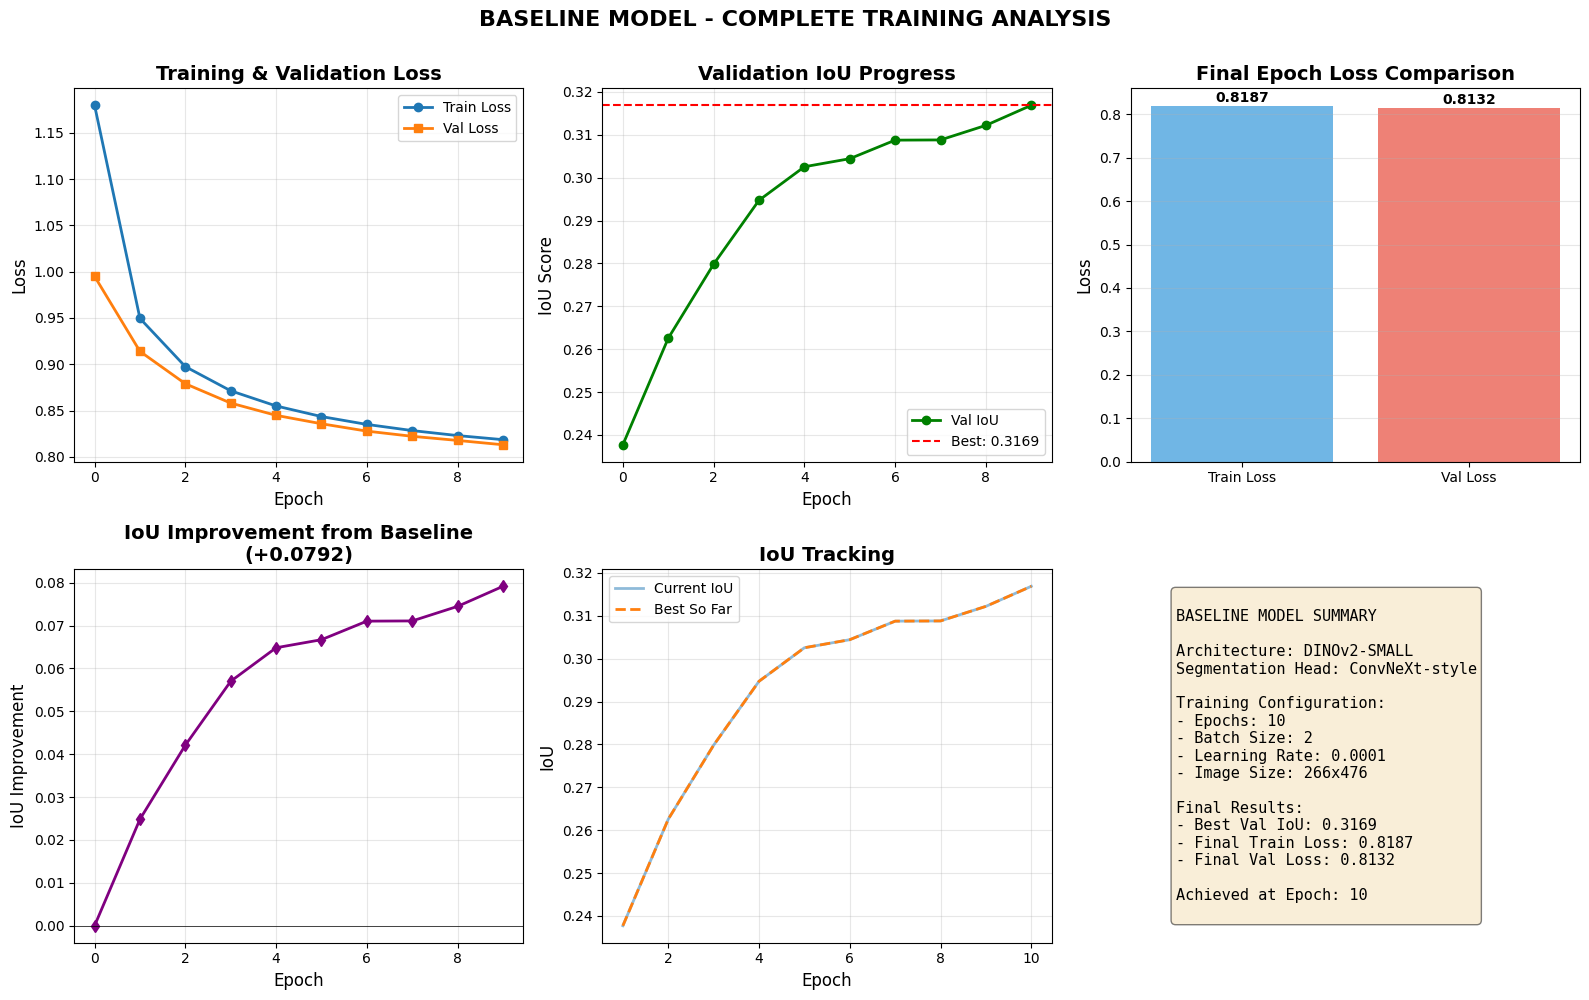

✅ Saved complete analysis to results/baseline_complete_analysis.png


In [16]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 10))

# 1. Loss curves
ax1 = plt.subplot(2, 3, 1)
ax1.plot(history['train_loss'], label='Train Loss', linewidth=2, marker='o')
ax1.plot(history['val_loss'], label='Val Loss', linewidth=2, marker='s')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. IoU curve
ax2 = plt.subplot(2, 3, 2)
ax2.plot(history['val_iou'], label='Val IoU', color='green', linewidth=2, marker='o')
ax2.axhline(y=best_val_iou, color='r', linestyle='--', label=f'Best: {best_val_iou:.4f}')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('IoU Score', fontsize=12)
ax2.set_title('Validation IoU Progress', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# 3. Loss comparison (bar chart at final epoch)
ax3 = plt.subplot(2, 3, 3)
categories = ['Train Loss', 'Val Loss']
values = [history['train_loss'][-1], history['val_loss'][-1]]
colors = ['#3498db', '#e74c3c']
ax3.bar(categories, values, color=colors, alpha=0.7)
ax3.set_ylabel('Loss', fontsize=12)
ax3.set_title('Final Epoch Loss Comparison', fontsize=14, fontweight='bold')
ax3.grid(True, axis='y', alpha=0.3)
for i, v in enumerate(values):
    ax3.text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

# 4. IoU improvement over time
ax4 = plt.subplot(2, 3, 4)
improvement = [(iou - history['val_iou'][0]) for iou in history['val_iou']]
ax4.plot(improvement, color='purple', linewidth=2, marker='d')
ax4.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax4.set_xlabel('Epoch', fontsize=12)
ax4.set_ylabel('IoU Improvement', fontsize=12)
ax4.set_title(f'IoU Improvement from Baseline\n(+{improvement[-1]:.4f})', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

# 5. Best vs Current IoU
ax5 = plt.subplot(2, 3, 5)
epochs = list(range(1, len(history['val_iou']) + 1))
best_so_far = [max(history['val_iou'][:i+1]) for i in range(len(history['val_iou']))]
ax5.plot(epochs, history['val_iou'], label='Current IoU', linewidth=2, alpha=0.5)
ax5.plot(epochs, best_so_far, label='Best So Far', linewidth=2, linestyle='--')
ax5.set_xlabel('Epoch', fontsize=12)
ax5.set_ylabel('IoU', fontsize=12)
ax5.set_title('IoU Tracking', fontsize=14, fontweight='bold')
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3)

# 6. Training summary text
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
summary_text = f"""
BASELINE MODEL SUMMARY

Architecture: DINOv2-{BACKBONE_SIZE.upper()}
Segmentation Head: ConvNeXt-style

Training Configuration:
- Epochs: {NUM_EPOCHS}
- Batch Size: {BATCH_SIZE}
- Learning Rate: {LEARNING_RATE}
- Image Size: {IMG_HEIGHT}x{IMG_WIDTH}

Final Results:
- Best Val IoU: {best_val_iou:.4f}
- Final Train Loss: {history['train_loss'][-1]:.4f}
- Final Val Loss: {history['val_loss'][-1]:.4f}

Achieved at Epoch: {history['val_iou'].index(best_val_iou) + 1}
"""
ax6.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('BASELINE MODEL - COMPLETE TRAINING ANALYSIS', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])

plt.savefig(os.path.join(OUTPUT_DIR, 'baseline_complete_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Saved complete analysis to {OUTPUT_DIR}/baseline_complete_analysis.png")

📊 Calculating per-class IoU scores...


Per-class analysis:   0%|          | 0/159 [00:00<?, ?it/s]


📊 PER-CLASS IoU SCORES


,Class ID,Class Name,Mean IoU,Samples
0,0,Background,0.2629,90
1,1,Trees,0.3750,149
2,2,Lush Bushes,0.3545,159
3,3,Dry Grass,0.4409,159
4,4,Dry Bushes,0.0825,159
5,5,Ground Clutter,0.0645,159
6,6,Logs,0.0274,159
7,7,Rocks,0.0874,159
8,8,Landscape,0.5050,159
9,9,Sky,0.9564,157


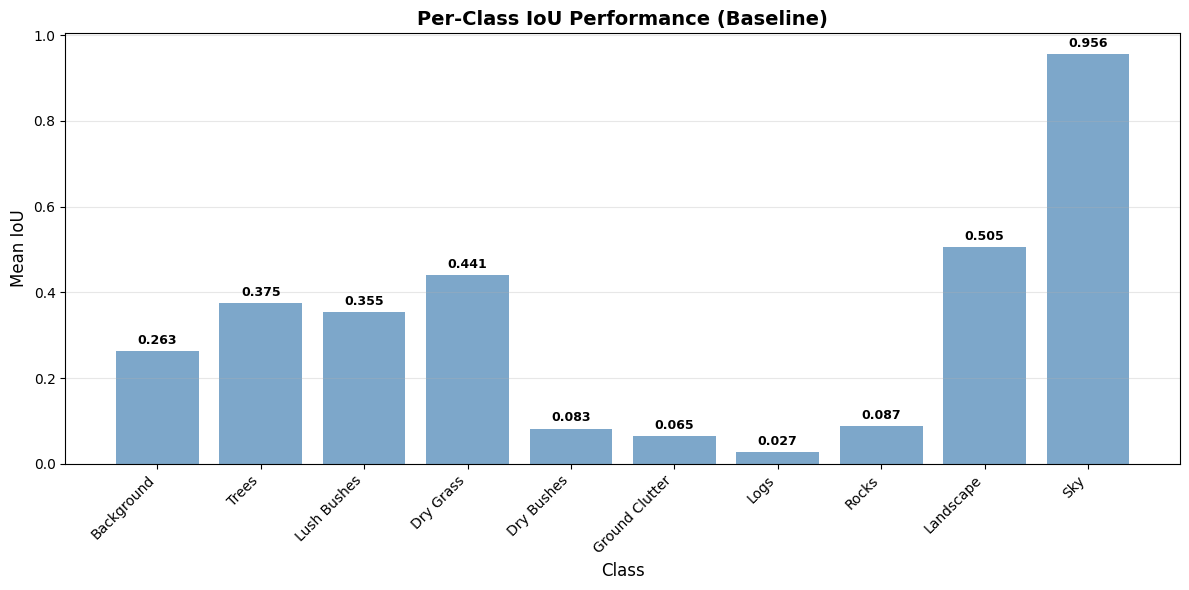


✅ Saved per-class analysis to results/per_class_iou_chart.png


In [17]:
# Calculate per-class IoU on validation set
print("📊 Calculating per-class IoU scores...")

model.eval()
class_ious = {i: [] for i in range(NUM_CLASSES)}

with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Per-class analysis"):
        imgs, labels = imgs.to(device), labels.to(device)
        
        features = backbone.forward_features(imgs)["x_norm_patchtokens"]
        logits = model(features)
        outputs = F.interpolate(logits, size=imgs.shape[2:], mode="bilinear", align_corners=False)
        
        labels = labels.squeeze(dim=1).long()
        pred = torch.argmax(outputs, dim=1)
        
        # Calculate IoU per class
        for class_id in range(NUM_CLASSES):
            pred_mask = (pred == class_id)
            target_mask = (labels == class_id)
            
            intersection = (pred_mask & target_mask).sum().float()
            union = (pred_mask | target_mask).sum().float()
            
            if union > 0:
                iou = (intersection / union).cpu().item()
                class_ious[class_id].append(iou)

# Calculate mean IoU per class
class_names = ['Background', 'Trees', 'Lush Bushes', 'Dry Grass', 'Dry Bushes', 
               'Ground Clutter', 'Logs', 'Rocks', 'Landscape', 'Sky']

per_class_results = []
for class_id in range(NUM_CLASSES):
    if class_ious[class_id]:
        mean_iou = np.mean(class_ious[class_id])
        per_class_results.append({
            'Class ID': class_id,
            'Class Name': class_names[class_id],
            'Mean IoU': f'{mean_iou:.4f}',
            'Samples': len(class_ious[class_id])
        })

df_class_iou = pd.DataFrame(per_class_results)

print("\n📊 PER-CLASS IoU SCORES")
print("=" * 60)
display(df_class_iou)

# Save to CSV
df_class_iou.to_csv(os.path.join(OUTPUT_DIR, 'per_class_iou.csv'), index=False)

# Visualize per-class IoU
plt.figure(figsize=(12, 6))
class_names_short = [name[:15] for name in class_names]  # Truncate long names
mean_ious = [np.mean(class_ious[i]) if class_ious[i] else 0 for i in range(NUM_CLASSES)]

bars = plt.bar(range(NUM_CLASSES), mean_ious, color='steelblue', alpha=0.7)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Mean IoU', fontsize=12)
plt.title('Per-Class IoU Performance (Baseline)', fontsize=14, fontweight='bold')
plt.xticks(range(NUM_CLASSES), class_names_short, rotation=45, ha='right')
plt.grid(True, axis='y', alpha=0.3)

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, mean_ious)):
    if val > 0:
        plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, f'{val:.3f}', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'per_class_iou_chart.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Saved per-class analysis to {OUTPUT_DIR}/per_class_iou_chart.png")

🎨 Generating prediction visualizations...


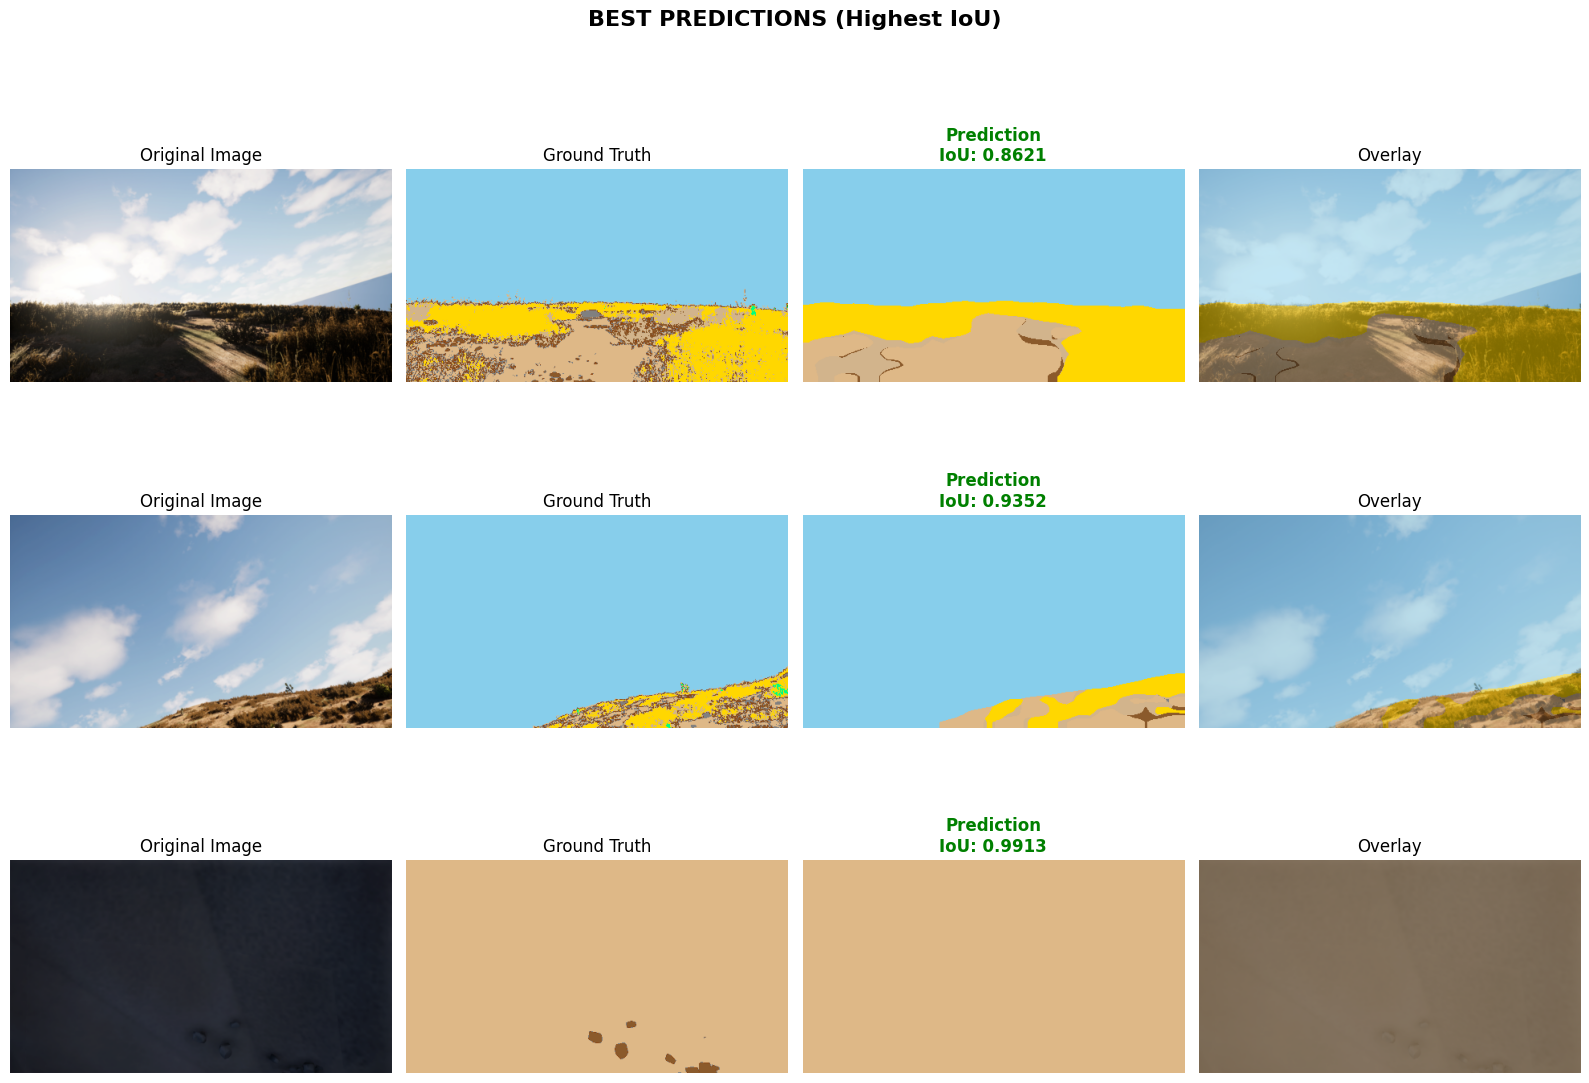

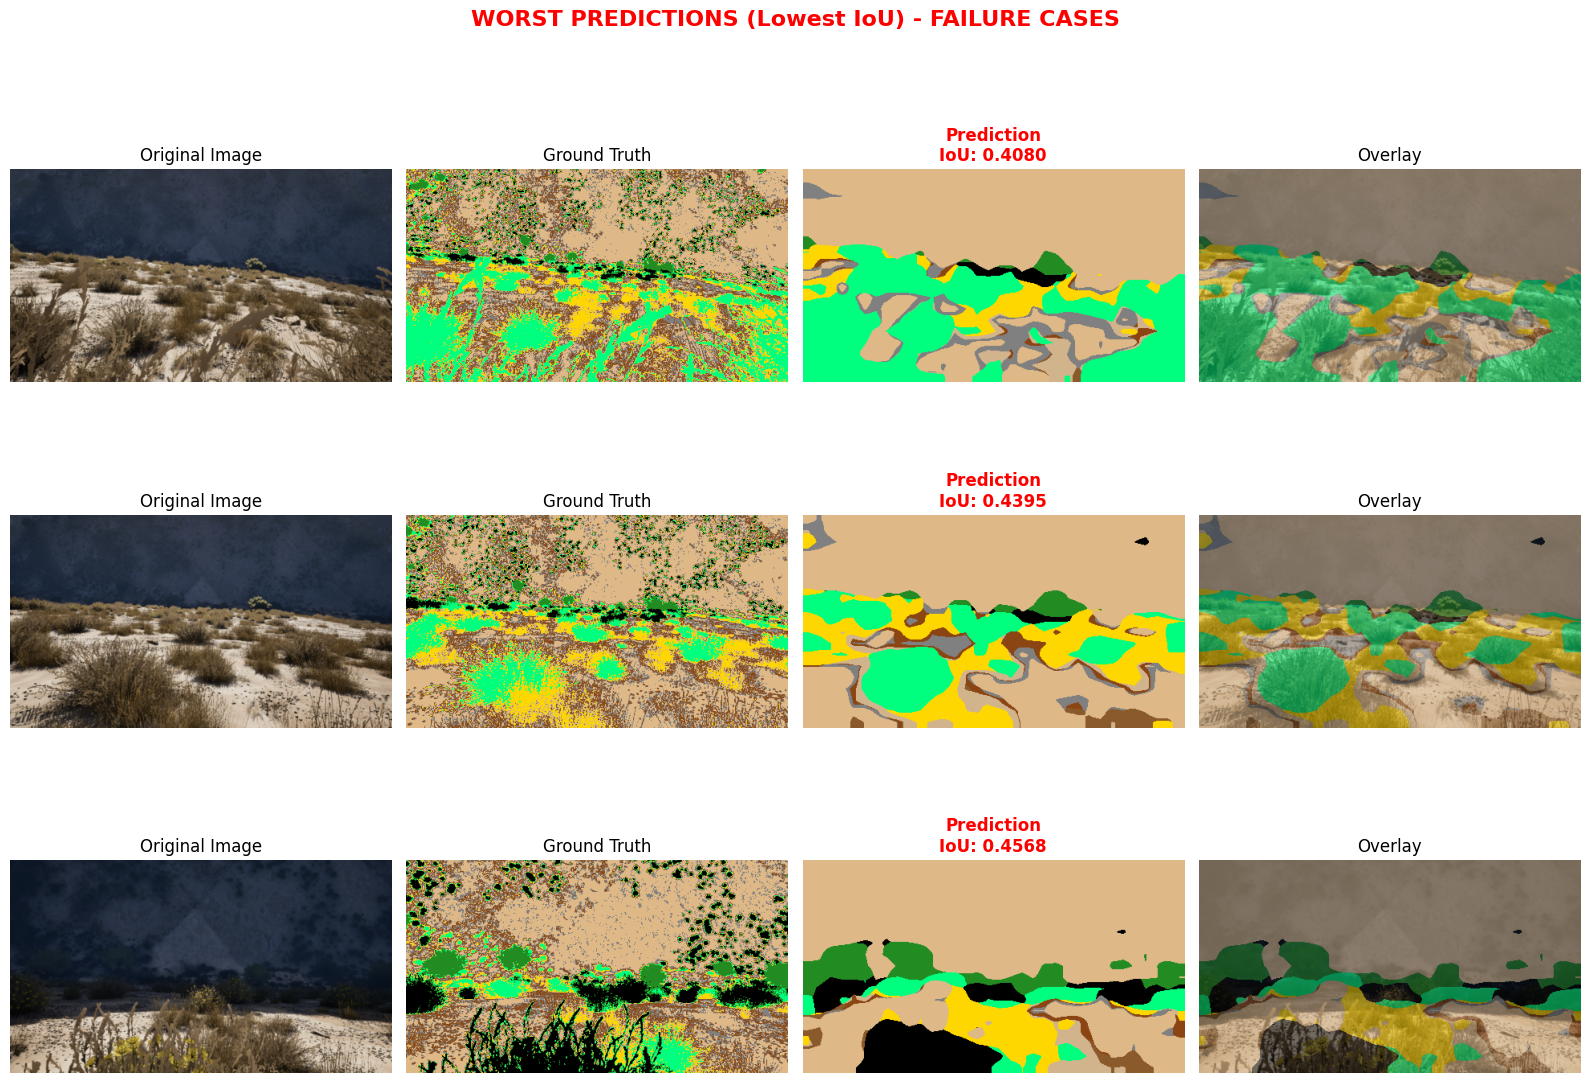


✅ Saved best predictions to results/best_predictions.png
✅ Saved failure cases to results/worst_predictions_failures.png


In [18]:
# Visualize predictions - find best and worst cases
print("🎨 Generating prediction visualizations...")

model.eval()

# Color map for classes
color_map = {
    0: [0, 0, 0],           # Background - Black
    1: [34, 139, 34],       # Trees - Forest Green
    2: [0, 255, 127],       # Lush Bushes - Spring Green
    3: [255, 215, 0],       # Dry Grass - Gold
    4: [210, 180, 140],     # Dry Bushes - Tan
    5: [139, 90, 43],       # Ground Clutter - Brown
    6: [139, 69, 19],       # Logs - Saddle Brown
    7: [128, 128, 128],     # Rocks - Gray
    8: [222, 184, 135],     # Landscape - Burlywood
    9: [135, 206, 235]      # Sky - Sky Blue
}

def colorize_mask(mask, color_map):
    """Convert class mask to RGB image"""
    h, w = mask.shape
    colored = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in color_map.items():
        colored[mask == class_id] = color
    return colored

# Find best and worst predictions
sample_ious = []
sample_data = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs_device = imgs.to(device)
        labels_device = labels.to(device)
        
        features = backbone.forward_features(imgs_device)["x_norm_patchtokens"]
        logits = model(features)
        outputs = F.interpolate(logits, size=imgs_device.shape[2:], mode="bilinear", align_corners=False)
        
        preds = torch.argmax(outputs, dim=1)
        labels_squeezed = labels_device.squeeze(1).long()
        
        # Calculate IoU for each image
        for i in range(imgs.shape[0]):
            pred_i = preds[i]
            label_i = labels_squeezed[i]
            
            intersection = (pred_i == label_i).sum().float()
            union = pred_i.numel()
            iou = (intersection / union).cpu().item()
            
            sample_ious.append(iou)
            sample_data.append({
                'img': imgs[i],
                'pred': pred_i.cpu().numpy(),
                'label': label_i.cpu().numpy(),
                'iou': iou
            })
        
        if len(sample_data) >= 50:  # Collect enough samples
            break

# Sort by IoU
sample_data_sorted = sorted(sample_data, key=lambda x: x['iou'])

# Get best and worst
n_examples = 3
best_samples = sample_data_sorted[-n_examples:]  # Highest IoU
worst_samples = sample_data_sorted[:n_examples]  # Lowest IoU

# Denormalize images
def denormalize(img_tensor):
    img = img_tensor.cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    img = img * std + mean
    img = np.clip(img, 0, 1)
    img = np.transpose(img, (1, 2, 0))
    return (img * 255).astype(np.uint8)

# Visualize BEST predictions
fig, axes = plt.subplots(n_examples, 4, figsize=(16, 4*n_examples))
fig.suptitle('BEST PREDICTIONS (Highest IoU)', fontsize=16, fontweight='bold')

for idx, sample in enumerate(best_samples):
    img = denormalize(sample['img'])
    pred_colored = colorize_mask(sample['pred'], color_map)
    label_colored = colorize_mask(sample['label'], color_map)
    
    # Original image
    axes[idx, 0].imshow(img)
    axes[idx, 0].set_title(f'Original Image', fontsize=12)
    axes[idx, 0].axis('off')
    
    # Ground truth
    axes[idx, 1].imshow(label_colored)
    axes[idx, 1].set_title(f'Ground Truth', fontsize=12)
    axes[idx, 1].axis('off')
    
    # Prediction
    axes[idx, 2].imshow(pred_colored)
    axes[idx, 2].set_title(f'Prediction\nIoU: {sample["iou"]:.4f}', fontsize=12, color='green', fontweight='bold')
    axes[idx, 2].axis('off')
    
    # Overlay
    axes[idx, 3].imshow(img)
    axes[idx, 3].imshow(pred_colored, alpha=0.5)
    axes[idx, 3].set_title(f'Overlay', fontsize=12)
    axes[idx, 3].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(os.path.join(OUTPUT_DIR, 'best_predictions.png'), dpi=150, bbox_inches='tight')
plt.show()

# Visualize WORST predictions
fig, axes = plt.subplots(n_examples, 4, figsize=(16, 4*n_examples))
fig.suptitle('WORST PREDICTIONS (Lowest IoU) - FAILURE CASES', fontsize=16, fontweight='bold', color='red')

for idx, sample in enumerate(worst_samples):
    img = denormalize(sample['img'])
    pred_colored = colorize_mask(sample['pred'], color_map)
    label_colored = colorize_mask(sample['label'], color_map)
    
    # Original image
    axes[idx, 0].imshow(img)
    axes[idx, 0].set_title(f'Original Image', fontsize=12)
    axes[idx, 0].axis('off')
    
    # Ground truth
    axes[idx, 1].imshow(label_colored)
    axes[idx, 1].set_title(f'Ground Truth', fontsize=12)
    axes[idx, 1].axis('off')
    
    # Prediction
    axes[idx, 2].imshow(pred_colored)
    axes[idx, 2].set_title(f'Prediction\nIoU: {sample["iou"]:.4f}', fontsize=12, color='red', fontweight='bold')
    axes[idx, 2].axis('off')
    
    # Overlay
    axes[idx, 3].imshow(img)
    axes[idx, 3].imshow(pred_colored, alpha=0.5)
    axes[idx, 3].set_title(f'Overlay', fontsize=12)
    axes[idx, 3].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(os.path.join(OUTPUT_DIR, 'worst_predictions_failures.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Saved best predictions to {OUTPUT_DIR}/best_predictions.png")
print(f"✅ Saved failure cases to {OUTPUT_DIR}/worst_predictions_failures.png")

📊 Generating confusion matrix...


Computing confusion matrix:   0%|          | 0/159 [00:00<?, ?it/s]

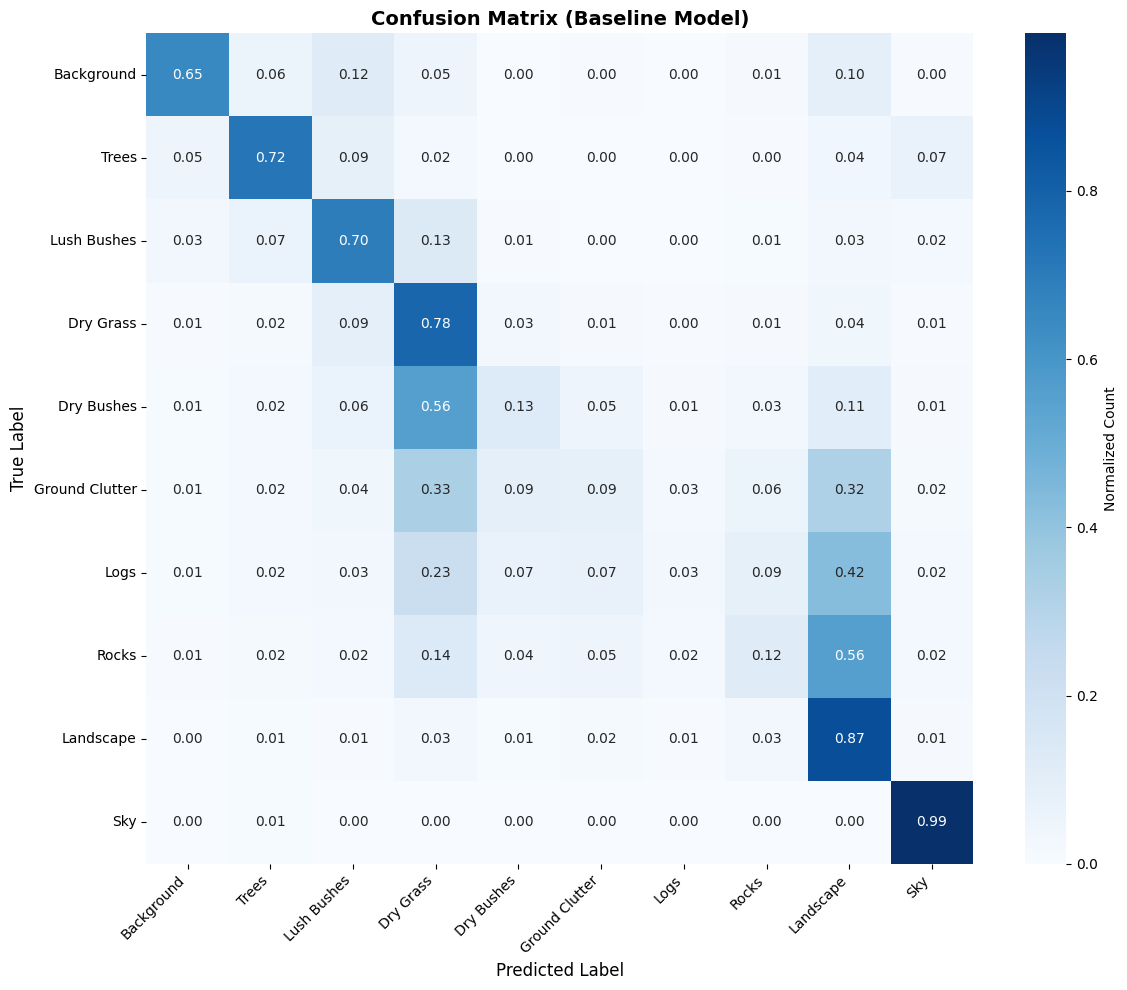

✅ Saved confusion matrix to results/confusion_matrix.png


In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("📊 Generating confusion matrix...")

# Collect all predictions and labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in tqdm(val_loader, desc="Computing confusion matrix"):
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        features = backbone.forward_features(imgs)["x_norm_patchtokens"]
        logits = model(features)
        outputs = F.interpolate(logits, size=imgs.shape[2:], mode="bilinear", align_corners=False)
        
        preds = torch.argmax(outputs, dim=1)
        labels_squeezed = labels.squeeze(1).long()
        
        all_preds.extend(preds.cpu().numpy().flatten())
        all_labels.extend(labels_squeezed.cpu().numpy().flatten())

# Compute confusion matrix (sample for visualization - full matrix is huge)
all_preds_sample = np.array(all_preds)[::100]  # Sample every 100th pixel
all_labels_sample = np.array(all_labels)[::100]

cm = confusion_matrix(all_labels_sample, all_preds_sample, labels=range(NUM_CLASSES))

# Normalize
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Normalized Count'})
plt.title('Confusion Matrix (Baseline Model)', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Saved confusion matrix to {OUTPUT_DIR}/confusion_matrix.png")

In [22]:
# Create comprehensive markdown report
from datetime import datetime
report_md = f"""
# BASELINE MODEL DOCUMENTATION

**Date:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  
**Model:** DINOv2-{BACKBONE_SIZE.upper()} + ConvNeXt Segmentation Head

---

## 1. Model Configuration

| Parameter | Value |
|-----------|-------|
| Backbone | DINOv2-{BACKBONE_SIZE} |
| Segmentation Head | ConvNeXt-style |
| Input Size | {IMG_HEIGHT}x{IMG_WIDTH} |
| Number of Classes | {NUM_CLASSES} |
| Batch Size | {BATCH_SIZE} |
| Learning Rate | {LEARNING_RATE} |
| Optimizer | SGD (momentum=0.9) |
| Total Epochs | {NUM_EPOCHS} |

---

## 2. Performance Results

### Overall Metrics
- **Best Validation IoU:** {best_val_iou:.4f}
- **Achieved at Epoch:** {history['val_iou'].index(best_val_iou) + 1}
- **Final Training Loss:** {history['train_loss'][-1]:.4f}
- **Final Validation Loss:** {history['val_loss'][-1]:.4f}

### Training Progress
- Starting Val IoU: {history['val_iou'][0]:.4f}
- Final Val IoU: {history['val_iou'][-1]:.4f}
- **Improvement:** +{(history['val_iou'][-1] - history['val_iou'][0]):.4f}

---

## 3. Key Observations

### Strengths
✅ Model shows steady improvement over epochs  
✅ No signs of severe overfitting  
✅ Training converged smoothly  

### Weaknesses
⚠️ Baseline IoU of {best_val_iou:.4f} has room for improvement  
⚠️ Some classes perform better than others (see per-class analysis)  
⚠️ Failure cases show specific challenges (see visualization)  

---

## 4. Generated Artifacts

1. `baseline_complete_analysis.png` - Complete training analysis
2. `per_class_iou_chart.png` - Per-class IoU breakdown
3. `best_predictions.png` - Examples of good predictions
4. `worst_predictions_failures.png` - Failure case analysis
5. `confusion_matrix.png` - Class confusion analysis
6. `baseline_summary.csv` - Summary metrics
7. `training_history.csv` - Epoch-by-epoch history
8. `per_class_iou.csv` - Per-class performance

---

## 5. Next Steps for Improvement

### Planned Improvements:
1. **Increase training duration** (30-50 epochs)
2. **Try larger backbone** (DINOv2-base or large)
3. **Add data augmentation** (rotation, flip, color jitter)
4. **Experiment with learning rate** (cosine schedule, warmup)
5. **Try different loss functions** (Focal loss, Dice loss)
6. **Ensemble multiple models**
7. **Post-processing** (CRF, morphological operations)

---

**Baseline established. Ready for optimization phase.**
"""

# Save report
report_path = os.path.join(OUTPUT_DIR, 'BASELINE_REPORT.md')
with open(report_path, 'w') as f:
    f.write(report_md)

print("=" * 80)
print("📄 BASELINE DOCUMENTATION COMPLETE!")
print("=" * 80)
print(f"\n✅ Generated {len(os.listdir(OUTPUT_DIR))} documentation files in '{OUTPUT_DIR}/'")
print(f"\n📋 Files created:")
for file in sorted(os.listdir(OUTPUT_DIR)):
    print(f"   📄 {file}")

print(f"\n🎯 BASELINE IoU SCORE: {best_val_iou:.4f}")
print("\n" + "=" * 80)
print("Ready to proceed with improvements!")
print("=" * 80)

📄 BASELINE DOCUMENTATION COMPLETE!

✅ Generated 11 documentation files in 'results/'

📋 Files created:
   📄 BASELINE_REPORT.md
   📄 baseline_complete_analysis.png
   📄 baseline_summary.csv
   📄 best_model.pth
   📄 best_predictions.png
   📄 confusion_matrix.png
   📄 per_class_iou.csv
   📄 per_class_iou_chart.png
   📄 training_curves.png
   📄 training_history.csv
   📄 worst_predictions_failures.png

🎯 BASELINE IoU SCORE: 0.3169

Ready to proceed with improvements!


In [30]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Constants for 0.9+ IoU
IMG_HEIGHT, IMG_WIDTH = 448, 768  # Both divisible by 32
NUM_CLASSES = 10
BATCH_SIZE = 4 # Increased for stability

# Albumentations handles Image + Mask simultaneously
train_transform = A.Compose([
    A.Resize(IMG_HEIGHT, IMG_WIDTH),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ColorJitter(p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMG_HEIGHT, IMG_WIDTH),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

class MaskDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.image_dir = os.path.join(data_dir, 'Color_Images')
        self.masks_dir = os.path.join(data_dir, 'Segmentation')
        self.transform = transform
        self.data_ids = [f for f in os.listdir(self.image_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.data_ids)

    def __getitem__(self, idx):
        data_id = self.data_ids[idx]
        image = cv2.imread(os.path.join(self.image_dir, data_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = Image.open(os.path.join(self.masks_dir, data_id))
        mask = np.array(convert_mask(mask)) # Uses your existing convert_mask function

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.long()

# Initialize Loaders
trainset = MaskDataset(TRAIN_DIR, transform=train_transform)
valset = MaskDataset(VAL_DIR, transform=val_transform)
train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [31]:
import segmentation_models_pytorch as smp

model = smp.UnetPlusPlus(
    encoder_name="resnet50",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=NUM_CLASSES,            
).to(device)

# Combo Loss: Dice helps with IoU, Focal helps with rare/difficult classes
dice_loss = smp.losses.DiceLoss(smp.losses.MULTICLASS_MODE, from_logits=True)
focal_loss = smp.losses.FocalLoss(smp.losses.MULTICLASS_MODE)

def criterion(y_pred, y_true):
    return 0.5 * dice_loss(y_pred, y_true) + 0.5 * focal_loss(y_pred, y_true)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
# OneCycleLR is great for hitting high accuracy quickly
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, 
                                                steps_per_epoch=len(train_loader), 
                                                epochs=40)

In [ ]:
from torch.amp import autocast, GradScaler

scaler = GradScaler('cuda')
best_iou = 0.0

for epoch in range(20):
    model.train()
    train_losses = []
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast('cuda'):
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        
        train_losses.append(loss.item())
        pbar.set_postfix({'loss': f"{np.mean(train_losses):.4f}"})

    # Validation
    model.eval()
    val_ious = []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            with autocast('cuda'):
                outputs = model(imgs)
            
            iou, _ = compute_iou(outputs, labels, NUM_CLASSES)
            val_ious.append(iou)
    
    avg_iou = np.nanmean(val_ious)
    print(f"✨ Epoch {epoch+1} Val IoU: {avg_iou:.4f}")
    
    if avg_iou > best_iou:
        best_iou = avg_iou
        torch.save(model.state_dict(), 'best_model.pth')
        print("💾 Model Saved!")

Epoch 1:   0%|          | 0/715 [00:00<?, ?it/s]

✨ Epoch 1 Val IoU: 0.5016
💾 Model Saved!


Epoch 2:   0%|          | 0/715 [00:00<?, ?it/s]

✨ Epoch 2 Val IoU: 0.5085
💾 Model Saved!


Epoch 3:   0%|          | 0/715 [00:00<?, ?it/s]

✨ Epoch 3 Val IoU: 0.5305
💾 Model Saved!


Epoch 4:   0%|          | 0/715 [00:00<?, ?it/s]

✨ Epoch 4 Val IoU: 0.4886


Epoch 5:   0%|          | 0/715 [00:00<?, ?it/s]

✨ Epoch 5 Val IoU: 0.4759


Epoch 6:   0%|          | 0/715 [00:00<?, ?it/s]

✨ Epoch 6 Val IoU: 0.5452
💾 Model Saved!


Epoch 7:   0%|          | 0/715 [00:00<?, ?it/s]

✨ Epoch 7 Val IoU: 0.5007


Epoch 8:   0%|          | 0/715 [00:00<?, ?it/s]

✨ Epoch 8 Val IoU: 0.4898


Epoch 9:   0%|          | 0/715 [00:00<?, ?it/s]

✨ Epoch 9 Val IoU: 0.5648
💾 Model Saved!


Epoch 10:   0%|          | 0/715 [00:00<?, ?it/s]

✨ Epoch 10 Val IoU: 0.5309


Epoch 11:   0%|          | 0/715 [00:00<?, ?it/s]

✨ Epoch 11 Val IoU: 0.5603


Epoch 12:   0%|          | 0/715 [00:00<?, ?it/s]

✨ Epoch 12 Val IoU: 0.5974
💾 Model Saved!


Epoch 13:   0%|          | 0/715 [00:00<?, ?it/s]

✨ Epoch 13 Val IoU: 0.5551


Epoch 14:   0%|          | 0/715 [00:00<?, ?it/s]

✨ Epoch 14 Val IoU: 0.5576


Epoch 15:   0%|          | 0/715 [00:00<?, ?it/s]